In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Final Project/model

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Final Project/model


###imports

In [ ]:
# !pip uninstall torch
# !pip install torch==1.10.0
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import torch
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from indrnn import IndRNNv2
from indrnn import IndRNN
import argparse


In [ ]:
def plotArray(arr):
  x=np.arange(0, len(arr))
  y=arr
  plt.title("Line graph")
  plt.xlabel("X axis")
  plt.ylabel("Y axis")
  plt.plot(x, y, color ="red")
  plt.show()
def into_graph(two_d_arr):
  for i in range(len(two_d_arr)):
    plotArray(two_d_arr[i])
def create_plot(arr,color,name):
  x=np.arange(0, len(arr))
  y=arr
  plt.xlabel("step")
  plt.ylabel("Score")
  plt.plot(x, y, color =color,label=name)



###load data

In [ ]:
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

def load_data(path,show_all=False):
  folders = os.listdir(path)
  my_x=[]
  my_y=[]
  for Class in folders:
    files=os.listdir(path+"/"+Class)
    for File in files:
      # print(path+"/"+Class+"/"+File, "is class is:"+ Class)
      CSVData = open(path+"/"+Class+"/"+File)
      Array2d_result = np.loadtxt(CSVData, delimiter=",")
      if show_all:
        print("Class:",Class)
        into_graph(Array2d_result)

      my_x.append(np.array(Array2d_result))
      my_y.append((float(Class)))
  # into_graph(my_x[0])
  tensor_x = torch.Tensor(my_x) # transform to torch tensor
  tensor_y = torch.Tensor(np.array(my_y)).type(torch.LongTensor)


  return TensorDataset(tensor_x,tensor_y)

###arguments

In [ ]:
# Hyper-parameters
sequence_length =1
num_points = 100
num_cols = 3
input_size =num_cols * num_points

hidden_size = input_size



#indrnn
lr=0.00002
time_steps=100
nlayer=3
no_cuda=False
batch_norm=True
bidirectional=True
log_interval=100
model_name="IndRNN"
batch_size=2048

num_layers = nlayer
num_classes = 4
num_epochs =500
learning_rate =lr
max_lr=0.001
grad_clip=0.1
criterion=nn.CrossEntropyLoss()


RECURRENT_MAX = pow(2, 1 / time_steps)

data_dir = './data'
print(os.listdir(data_dir))
classes = os.listdir(data_dir +"/loc/train")
print(classes)

['acc', 'vel', 'loc', 'gifs']
['3', '2', '1', '0']


###model

In [ ]:
class persona_Net(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer=2, model=IndRNN,model_is_initialize=False):
        super(persona_Net, self).__init__()
        recurrent_inits = [lambda w: nn.init.uniform_(
            w, -RECURRENT_MAX, RECURRENT_MAX)]
        for _ in range(1, n_layer):
            recurrent_inits.append(lambda w: nn.init.constant_(w, 1))
        if model_is_initialize:
          self.indrnn=model
        else:
          self.indrnn = model(
              input_size, hidden_size,
              n_layer, batch_norm=batch_norm,
              bidirectional=bidirectional,
              hidden_max_abs=RECURRENT_MAX,
              recurrent_inits=recurrent_inits)
        self.lin = nn.Linear(
            hidden_size * 2 if bidirectional else hidden_size, 1)
        self.fc = nn.Linear( hidden_size * 2 if bidirectional else hidden_size, num_classes)
        self.fc.bias.data.fill_(.1)
        self.fc.weight.data.normal_(0,.01)
        
        self.conv1=torch.nn.Conv2d(2,16,2)
        self.conv2=torch.nn.Conv2d(16,8,1)
        self.conv3=torch.nn.Conv2d(16,2,1)
        self.conv3=torch.nn.Conv2d(2,1,1)
        self.max=nn.MaxPool1d(3, stride=2)


    def forward(self, x,x2d, hidden=None):
        y_1, _ = self.indrnn(x, hidden)
        return self.fc(y[:, -1, :])
        # return self.lin(y[-1]).squeeze(1)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, n_layer=2, model=IndRNN,model_is_initialize=False):
        super(Net, self).__init__()
        recurrent_inits = [lambda w: nn.init.uniform_(
            w, -RECURRENT_MAX, RECURRENT_MAX)]
        for _ in range(1, n_layer):
            recurrent_inits.append(lambda w: nn.init.constant_(w, 1))
        if model_is_initialize:
          self.indrnn=model
        else:
          self.indrnn = model(
              input_size, hidden_size,
              n_layer, batch_norm=batch_norm,
              bidirectional=bidirectional,
              hidden_max_abs=RECURRENT_MAX,
              recurrent_inits=recurrent_inits)
        self.lin = nn.Linear(
            hidden_size * 2 if bidirectional else hidden_size, 1)
        self.fc = nn.Linear( hidden_size * 2 if bidirectional else hidden_size, num_classes)
        self.fc.bias.data.fill_(.1)
        self.fc.weight.data.normal_(0,.01)
    def forward(self, x, hidden=None):
        y, _ = self.indrnn(x, hidden)
        return self.fc(y[:, -1, :])
        # return self.lin(y[-1]).squeeze(1)

In [ ]:
import torchvision.models as models
class My_nn(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(My_nn, self).__init__()
    input=input_size
    self.conv1_bn=nn.BatchNorm1d(1)

    self.conv1=torch.nn.Conv1d(1,4,1)
    self.conv2=torch.nn.Conv1d(4,16,3)
    self.conv3=torch.nn.Conv1d(16,64,3)

    self.conv4=torch.nn.Conv1d(64,32,3)
    self.conv5=torch.nn.Conv1d(32,16,3)
    self.conv6=torch.nn.Conv1d(16,8,3)
    self.conv7=torch.nn.Conv1d(8,4,3)
    self.conv8=torch.nn.Conv1d(4,2,1)
    self.conv9=torch.nn.Conv1d(2,1,1)
    self.max=nn.MaxPool1d(3, stride=2)
    self.softmax = nn.LogSoftmax()

    self.fc = nn.Linear(int((input-2*6)), num_classes)

    pass

  def forward(self, x):
    out=x
    out=self.conv1_bn(out)
    out=self.conv1(out)
    out=self.conv2(out)
    out=self.conv3(out)

    out=self.conv4(out)
    out=self.conv5(out)
    out=self.conv6(out)
    out=self.conv7(out)
    out=self.conv8(out)
    out=self.conv9(out)
    # out=self.max(out)

    out = self.fc(out[:, -1, :])

    # out=self.softmax(out)
    return out

    pass
       
class _My_nn(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(_My_nn, self).__init__()
    input=input_size

    self.conv1_bn=nn.BatchNorm1d(1)
    # self.conv1=torch.nn.Conv1d(1,4,5)
    # self.conv2=torch.nn.Conv1d(4,16,5)
    self.conv1=torch.nn.Conv1d(1,4,1)
    self.conv2=torch.nn.Conv1d(4,16,1)
    self.conv2_2=torch.nn.Conv1d(16,2,1)
    # self.conv1_1=torch.nn.Conv1d(32,1,1)

    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.max=nn.MaxPool1d(3, stride=2)


    # self.lstm = nn.LSTM(input-8, hidden_size, num_layers, batch_first=True)
    self.lstm = nn.LSTM(input, hidden_size, num_layers, batch_first=True)

    self.conv2_bn=nn.BatchNorm1d(2)
    self.conv3=torch.nn.Conv1d(2,1,1)
    # self.conv4=torch.nn.Conv1d(4,2,5)
    # self.conv5=torch.nn.Conv1d(2,1,5)
    # self.max2=nn.MaxPool1d(3, stride=2)
    self.lstm_2 = nn.LSTM(input, hidden_size, num_layers, batch_first=True)
    # self.lstm_2 = nn.LSTM(int((input-13)/2), hidden_size, num_layers, batch_first=True)
    # self.lstm_2 = nn.LSTM(input-12, hidden_size, num_layers, batch_first=True)

    # self.conv5=torch.nn.Conv1d(12,1,1)
    self.softmax = nn.Softmax(dim=1)
    self.fc = nn.Linear(hidden_size, num_classes)

    pass
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    out=x

    # out=self.conv1_bn(out)
    out=self.conv1(out)
    out=self.conv2(out)
    out=self.conv2_2(out)
    # out=self.conv1_1(out)

    out, _ = self.lstm(out, (h0, c0))

    out=self.conv2_bn(out)
    out=self.conv3(out)
    # out=self.conv4(out)
    # out=self.conv5(out)
    # out=self.max2(out)
    out, _ = self.lstm_2(out, (h0, c0))

    # out=self.conv5(out)
    # out=self.softmax(out)
    out = self.fc(out[:, -1, :])
    return out
    pass

In [ ]:
# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

###Train

In [ ]:

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train(test_loader,train_loader,num_epochs,sequence_length,input_size,model,optimizer,max_lr=0.01,grad_clip=0.1):
  # Train the model
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=num_epochs,
                                                steps_per_epoch=len(train_loader))
  total_step = len(train_loader)
  lrs = []

  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):


          images = images.reshape(-1,sequence_length, input_size).to(device)


          labels = labels.to(device)
          
          # Forward pass
          outputs = model(images)
          # loss = criterion(outputs, torch.max(labels, 1)[1])
          # Backward and optimize
          # loss = F.mse_loss(outputs, labels)
          loss = criterion(outputs, labels)

          loss.backward()
          if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
          optimizer.step()
          optimizer.zero_grad()
          current_lr=get_lr(optimizer)
          lrs.append(current_lr)
          sched.step()
          if epoch % 100==0:
            testing(model,test_loader)
            pass
          if epoch % 10 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, lr: {:.6f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item(),current_lr))

In [ ]:
def train_test_multi(test_loader,train_loader,num_epochs,sequence_length,input_size,
                     model_A,optimizer_A,model_name_A,
                     max_lr=0.01,grad_clip=0.1,
                     model_B=None,optimizer_B=None,model_name_B=None,
                     model_C=None,optimizer_C=None,model_name_C=None):
  # Train the model
  sched_A = torch.optim.lr_scheduler.OneCycleLR(optimizer_A, max_lr, epochs=num_epochs,
                                                steps_per_epoch=len(train_loader))
  if model_B!=None:
    sched_B = torch.optim.lr_scheduler.OneCycleLR(optimizer_B, max_lr, epochs=num_epochs,
                                                steps_per_epoch=len(train_loader))
  if model_C!=None:
    # sched_C = torch.optim.lr_scheduler.OneCycleLR(optimizer_C, max_lr, epochs=num_epochs,
    #                                             steps_per_epoch=len(train_loader))    
    pass
  total_step = len(train_loader)
  lrs_A = []
  lrs_B = []
  lrs_C = []
  score_A,score_B,score_C=[],[],[]
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):


          images = images.reshape(-1,sequence_length, input_size).to(device)


          labels = labels.to(device)
          
          # Forward pass
          outputs_A = model_A(images)
          if model_B!=None:
            outputs_B = model_B(images)
            pass
          if model_C!=None:
            outputs_C = model_C(images)
            pass
          # loss = criterion(outputs, torch.max(labels, 1)[1])
          # Backward and optimize
          # loss = F.mse_loss(outputs, labels)

          loss_A = criterion(outputs_A, labels)
          loss_A.backward()
          if grad_clip:
                nn.utils.clip_grad_value_(model_A.parameters(), grad_clip)
          optimizer_A.step()
          optimizer_A.zero_grad()
          current_lr_A=get_lr(optimizer_A)
          lrs_A.append(current_lr_A)
          sched_A.step() 
               
          if model_B!=None:
            loss_B = criterion(outputs_B, labels)
            loss_B.backward()
            if grad_clip:
              nn.utils.clip_grad_value_(model_B.parameters(), grad_clip)
            optimizer_B.step()
            optimizer_B.zero_grad()
            current_lr_B=get_lr(optimizer_B)
            lrs_B.append(current_lr_B)
            sched_B.step()   

          if model_C!=None:
            loss_C = criterion(outputs_C, labels)
            optimizer_C.zero_grad()
            loss_C.backward()
            if grad_clip:
              nn.utils.clip_grad_value_(model_C.parameters(), grad_clip) 
            optimizer_C.step()
            
            current_lr_C=get_lr(optimizer_C)
            lrs_C.append(current_lr_C)
            # sched_C.step()
                                              
          if epoch % 100==0:
            print("results on model: ",model_name_A)
            score_A.append(testing(model_A,test_loader))
            if model_B!=None:
              print("results on model: ",model_name_B)
              score_B.append(testing(model_B,test_loader))
            if model_C!=None:
              print("results on model: ",model_name_C)
              score_C.append(testing(model_C,test_loader))


            pass
          if epoch % 20 == 0:
            Str='Epoch [{}/{}], Step [{}/{}]'.format(epoch+1, num_epochs, i+1, total_step)
            Str+=  ',Loss of model '+model_name_A+': {:.4f}, lr: {:.6f}'.format(loss_A.item(),current_lr_A)
            if model_B!=None:
              Str+=',Loss of model '+model_name_B+': {:.4f}, lr: {:.6f}'.format(loss_B.item(),current_lr_B)
            if model_C!=None:
              Str+=',Loss of model '+model_name_C+': {:.4f}, lr: {:.6f}'.format(loss_C.item(),current_lr_C)
            # print(Str)   
            # print ('Epoch [{}/{}], Step [{}/{}], Loss of model '+model_name_A+': {:.4f}, lr: {:.6f},Loss of model '+model_name_B+': {:.4f}, lr: {:.6f},Loss of model '+model_name_C+': {:.4f}, lr: {:.6f}' 
            #         .format(epoch+1, num_epochs, i+1, total_step, loss_A.item(),current_lr_A)
  print("results on model: ",model_name_A)
  score_A.append(testing(model_A,test_loader))
  if model_B!=None:
    print("results on model: ",model_name_B)
    score_B.append(testing(model_B,test_loader))
  if model_C!=None:
    print("results on model: ",model_name_C)
    score_C.append(testing(model_C,test_loader))

  print("finished")
  return score_A,score_B,score_C

In [ ]:
def get_batch():
    """Generate the adding problem dataset"""
    # Build the first sequence
    add_values = torch.rand(
        time_steps, batch_size, requires_grad=False
    )

    # Build the second sequence with one 1 in each half and 0s otherwise
    add_indices = torch.zeros_like(add_values)
    print("add_indices",add_indices,add_indices.shape)
    half = int(time_steps / 2)
    for i in range(batch_size):
        first_half = np.random.randint(half)
        second_half = np.random.randint(half, time_steps)
        add_indices[first_half, i] = 1
        add_indices[second_half, i] = 1
        print(add_indices)

    # Zip the values and indices in a third dimension:
    # inputs has the shape (time_steps, batch_size, 2)
    inputs = torch.stack((add_values, add_indices), dim=-1)
    targets = torch.mul(add_values, add_indices).sum(dim=0)
    return inputs, targets

In [ ]:


def new_train(model,optimizer):
  from time import time
  # Train the model
  model.train()
  step = 0
  while True:
    losses = []
    start = time()
    for _ in range(log_interval):
      # Generate new input data
      data, target = get_batch()

      if True:
        data, target = data.cuda(), target.cuda()
      model.zero_grad()
      out = model(data)
      print("out",out.shape)
      loss = F.mse_loss(out, target)
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
      step += 1

    print("MSE after {} iterations: {} ({} sec.)".format(step, np.mean(losses), time() - start))

###Test

In [ ]:
# Test the model
def testing(model,test_loader):
  # model.eval()
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.reshape(-1,sequence_length, input_size).to(device)

          labels = labels.to(device)
          outputs = model(images)

          _, predicted = torch.max(outputs.data, 1)

          total += labels.size(0)

          correct += (predicted == labels).sum().item()

      # print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total)) 
      print('Test Accuracy of the model on '+str(total)+' samples is: {}%'.format(100 * correct / total)+', '+str(correct)+' was correct') 

  return 100 * correct / total

###Main

In [ ]:
def create_raw_model_IRNN(input_size, hidden_size,n_layer):# the model itself ,probly tryting to create irnn nodes and test how to connect it directily 
        recurrent_inits = [lambda w: nn.init.uniform_(
            w, -RECURRENT_MAX, RECURRENT_MAX)]
        for _ in range(1, n_layer):
            recurrent_inits.append(lambda w: nn.init.constant_(w, 1))


        RE= IndRNN(
            input_size, hidden_size,
            n_layer, batch_norm=batch_norm,
            bidirectional=bidirectional,
            hidden_max_abs=RECURRENT_MAX,
            recurrent_inits=recurrent_inits)
        return RE

In [ ]:

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# #Data transforms (normalization and data augmentation)

# train_dataset = load_data(data_dir+'/train')
# test_dataset = load_data(data_dir+'/test')

# # Data loader

# train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
#                                            batch_size=batch_size, 
#                                            shuffle=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size, 
#                                           shuffle=False)
# model_RNN = RNN(input_size, hidden_size, num_layers,num_classes).to(device)
# optimizer_RNN = torch.optim.Adam(model_RNN.parameters(), lr=learning_rate)
# # train(test_loader,train_loader,num_epochs,sequence_length,input_size,model_RNN,optimizer_RNN,max_lr,grad_clip)


FileNotFoundError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


results on model:  CNN
Test Accuracy of the model on 40 samples is: 30.0%, 12 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 17.5%, 7 was correct
results on model:  IRNN
Test Accuracy of the model on 40 samples is: 45.0%, 18 was correct
results on model:  CNN
Test Accuracy of the model on 40 samples is: 57.5%, 23 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 85.0%, 34 was correct
results on model:  IRNN
Test Accuracy of the model on 40 samples is: 65.0%, 26 was correct
results on model:  CNN
Test Accuracy of the model on 40 samples is: 72.5%, 29 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 90.0%, 36 was correct
results on model:  IRNN
Test Accuracy of the model on 40 samples is: 80.0%, 32 was correct
results on model:  CNN
Test Accuracy of the model on 40 samples is: 72.5%, 29 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 87.5%, 35 was correct
results 

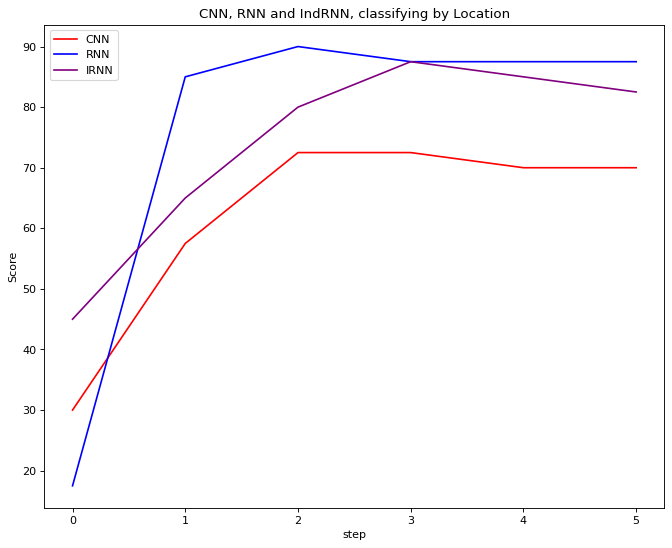

87.5
results on model:  CNN
Test Accuracy of the model on 40 samples is: 17.5%, 7 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 30.0%, 12 was correct
results on model:  IRNN
Test Accuracy of the model on 40 samples is: 37.5%, 15 was correct
results on model:  CNN
Test Accuracy of the model on 40 samples is: 50.0%, 20 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 75.0%, 30 was correct
results on model:  IRNN
Test Accuracy of the model on 40 samples is: 85.0%, 34 was correct
results on model:  CNN
Test Accuracy of the model on 40 samples is: 70.0%, 28 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 87.5%, 35 was correct
results on model:  IRNN
Test Accuracy of the model on 40 samples is: 80.0%, 32 was correct
results on model:  CNN
Test Accuracy of the model on 40 samples is: 70.0%, 28 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 87.5%, 35 was correct
res

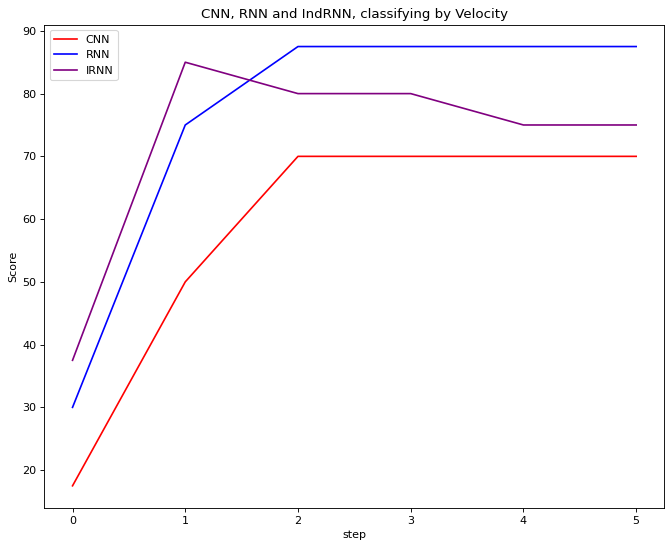

87.5
results on model:  CNN
Test Accuracy of the model on 40 samples is: 25.0%, 10 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 25.0%, 10 was correct
results on model:  IRNN
Test Accuracy of the model on 40 samples is: 47.5%, 19 was correct
results on model:  CNN
Test Accuracy of the model on 40 samples is: 75.0%, 30 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 60.0%, 24 was correct
results on model:  IRNN
Test Accuracy of the model on 40 samples is: 85.0%, 34 was correct
results on model:  CNN
Test Accuracy of the model on 40 samples is: 72.5%, 29 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 85.0%, 34 was correct
results on model:  IRNN
Test Accuracy of the model on 40 samples is: 90.0%, 36 was correct
results on model:  CNN
Test Accuracy of the model on 40 samples is: 57.5%, 23 was correct
results on model:  RNN
Test Accuracy of the model on 40 samples is: 87.5%, 35 was correct
re

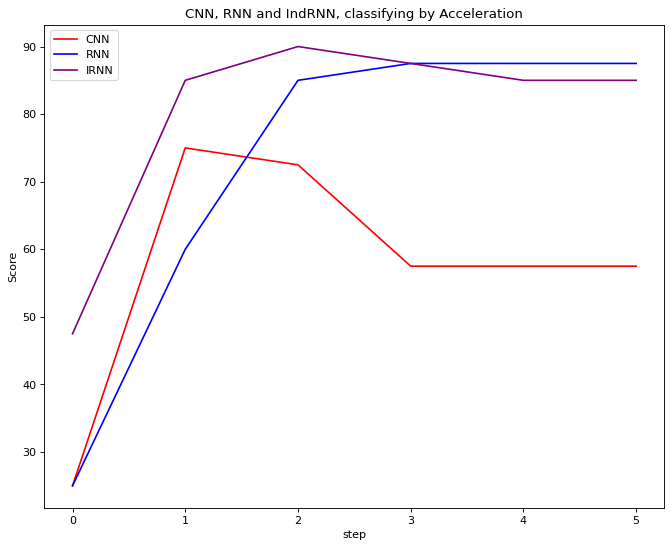

87.5


In [ ]:
#main


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Data transforms (normalization and data augmentation)
lva = ["loc","vel","acc"]
lva_full = ["Location","Velocity","Acceleration"]
for j in range(len(lva)):
  train_dataset = load_data(data_dir+f'/{lva[j]}'+'/train')
  test_dataset = load_data(data_dir+f'/{lva[j]}'+'/test')

  # Data loader

  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size, 
                                            shuffle=True)

  test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size, 
                                            shuffle=False)

  sum=0

  for i in range(1):
    #create the model
    RAW_IRNN=create_raw_model_IRNN(input_size, hidden_size, num_layers)
    model_CNN = My_nn(input_size, hidden_size, num_layers, num_classes).to(device)
    # model_RNN = Net(input_size, hidden_size, num_layers,num_classes).to(device)
    model_RNN = RNN(input_size, hidden_size, num_layers,num_classes).to(device)
    # model_RNN = Net(input_size, hidden_size, num_layers,RAW_IRNN,True).to(device) # learning decay 
    # model_RNN = RNN(input_size, hidden_size, num_layers,num_classes).to(device)
    
    # model_IRNN = Net(input_size, hidden_size, num_layers,RAW_IRNN,True).to(device) # no learning decay 
    model_IRNN = Net(input_size, hidden_size, num_layers,RAW_IRNN,True).to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer_CNN = torch.optim.Adam(model_CNN.parameters(), lr=learning_rate)
    optimizer_RNN = torch.optim.Adam(model_RNN.parameters(), lr=learning_rate)
    optimizer_IRNN = torch.optim.Adam(model_IRNN.parameters(), lr=learning_rate)

    # new_train(model,optimizer)

    # Train the model

    # train(test_loader,train_loader,num_epochs,sequence_length,input_size,model_RNN,optimizer_RNN,max_lr,grad_clip)
    score_A,score_B,score_C=train_test_multi(test_loader,train_loader,num_epochs,sequence_length,input_size,
                      model_CNN,optimizer_CNN,"CNN",
                      max_lr=max_lr,grad_clip=grad_clip,
                      model_B=model_RNN,optimizer_B=optimizer_RNN,model_name_B="RNN",
                      model_C=model_IRNN,optimizer_C=optimizer_IRNN,model_name_C="IRNN")
    sum+=testing(model_RNN,test_loader)
    # Test the model
    # sum+=testing(model,test_loader)
    plt.figure(figsize=(10, 8), dpi=80)
    plt.title(f"CNN, RNN and IndRNN, classifying by {lva_full[j]}")

    create_plot(score_A,"red","CNN")
    create_plot(score_B,"blue","RNN")
    create_plot(score_C,"purple","IRNN")
    plt.legend()
    plt.show()
  print(sum)


In [ ]:
device = torch.device('cuda')
print(sum)
print("test before save")
testing(model_RNN,test_loader)
device = torch.device('cpu')
# rawirnn=model_CNN.indrnn.state_dict()
PATH='./model_rnn'
torch.save(model_RNN.state_dict(), PATH)
print("test after save")

model_test =  RNN(input_size, hidden_size, num_layers,4).to(device)
model_test.load_state_dict(torch.load(PATH))
# model_test.indrnn.load_state_dict(rawirnn)
model_test.eval()
testing(model_test,test_loader)

87.5
test before save
Test Accuracy of the model on 40 samples is: 87.5%, 35 was correct
test after save
Test Accuracy of the model on 40 samples is: 87.5%, 35 was correct


87.5

In [ ]:
device = torch.device('cuda')

In [ ]:
# testing(model_test,test_loader)

In [ ]:
# irnn = independent rnn
# torch.__version__
